# CSE 151A Project - Detecting Alzheimer's via MRI Images Using CNNs and QCNNs

## 1. Setup

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp "/content/drive/MyDrive/Kaggle_API/kaggle.json" ~/.kaggle/

cp: cannot stat '/content/drive/MyDrive/Kaggle_API/kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
 91% 31.0M/34.1M [00:00<00:00, 136MB/s] 
100% 34.1M/34.1M [00:00<00:00, 121MB/s]


In [ ]:
! unzip alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
#paths for dataset
alzheimer_train = "Alzheimer_s Dataset/train"
alzheimer_test = "Alzheimer_s Dataset/test"

## 2. Data Exploration

### 2.1. Image Sizes

In [ ]:
def check_size(data_folder):
  #code from medium article
    folders = os.listdir(data_folder)
    images = []
    image_shapes = []

    for folder in folders:
      folder_path = os.path.join(data_folder, folder)
      for path in os.listdir(folder_path):
        image_path = os.path.join(os.path.join(data_folder, folder), path)
        image = cv2.imread(image_path)

        # Convert to RGB as OpenCV uses BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

        # Obtain shape of each image and store them in an array
        (width, height) = image.shape[1], image.shape[0]
        image_shapes.append((width, height))

    # Return only unique shapes
    unique_shapes = list(set(image_shapes))
    return unique_shapes

In [ ]:
check_size(alzheimer_train)

[(176, 208)]

In [ ]:
check_size(alzheimer_test)

[(176, 208)]

### 2.2. Classes and Image Count

In [ ]:
def check_image_count(data_folder):
  total_count = 0
  class_dict = {}
  for root, dirs, files in os.walk(data_folder):
    if root != data_folder:
      folder_name = os.path.basename(root)
      file_count = len(files)
      total_count += file_count
      class_dict[folder_name] = file_count
  return class_dict

In [ ]:
# Plot the classes and the number of samples for each (training data).
def plot_classes_training():
  class_dict = check_image_count(alzheimer_train)
  classes = list(class_dict.keys())
  counts = list(class_dict.values())

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(classes, counts, color='skyblue')
  plt.title('Histogram of classes and number of samples for training data.')
  plt.show()
  return

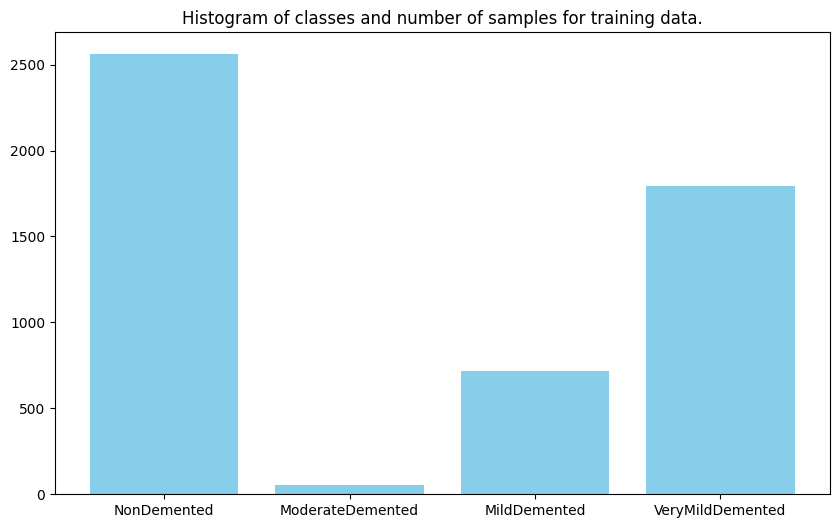

In [ ]:
plot_classes_training()

In [ ]:
# Plot the classes and the number of samples for each (test data).
def plot_classes_test():
  class_dict = check_image_count(alzheimer_test)
  classes = list(class_dict.keys())
  counts = list(class_dict.values())

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(classes, counts, color='green')
  plt.title('Histogram of classes and number of samples for test data.')
  plt.show()
  return

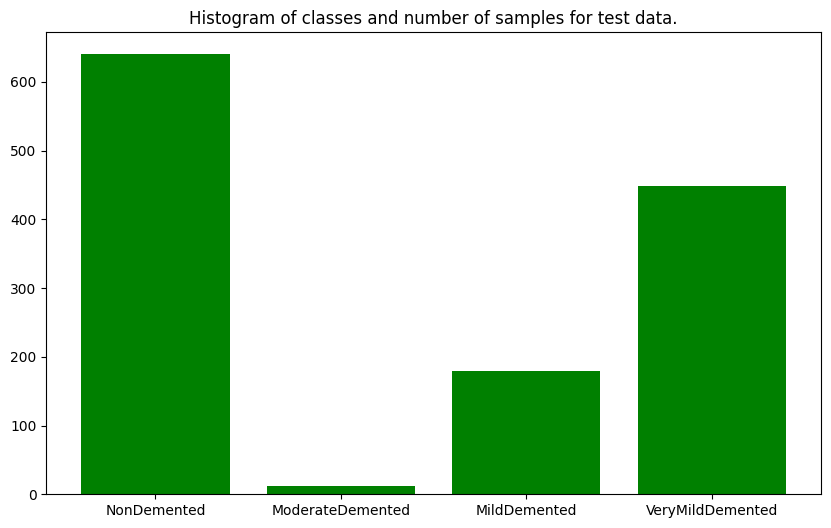

In [ ]:
plot_classes_test()

### 2.3. Bluriness Check

In [ ]:
def check_image_blurriness(data_folder, threshold=100):
    blurry_images = []
    clear_thresholds = []

    folders = os.listdir(data_folder)

    for folder in folders:
        folder_path = os.path.join(data_folder, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Compute the Laplacian of the image and then the variance
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

            # Determine if the image is blurry based on the threshold
            if laplacian_var < threshold:
                blurry_images.append(image_path)
                print(f"Blurry image found in {data_folder}: {image_path} (Variance of Laplacian: {laplacian_var})")
            else:
                clear_thresholds.append(laplacian_var)

    # Calculate average clear threshold for non-blurry images
    if clear_thresholds:
        average_threshold = sum(clear_thresholds) / len(clear_thresholds)
        print(f"Average threshold for non-blurry images in {data_folder}: {average_threshold}")
    else:
        average_threshold = None
        print(f"No clear images found in {data_folder}.")

    return blurry_images, average_threshold

# Example usage:
alzheimer_train = "Alzheimer_s Dataset/train"
alzheimer_test = "Alzheimer_s Dataset/test"

In [ ]:
alzheimer_train = "Alzheimer_s Dataset/train"
alzheimer_test = "Alzheimer_s Dataset/test"

train_blurry_images, avg_threshold_train = check_image_blurriness(alzheimer_train)
print()
test_blurry_images, avg_threshold_test = check_image_blurriness(alzheimer_test)

print("\nBlurry images in training set:")
print(train_blurry_images)

print("\nBlurry images in test set:")
print(test_blurry_images)

Average threshold for non-blurry images in Alzheimer_s Dataset/train: 665.2642515184098

Average threshold for non-blurry images in Alzheimer_s Dataset/test: 608.2684376315634

Blurry images in training set:
[]

Blurry images in test set:
[]


### 2.4. Color Distribution

In [ ]:
def check_color_distribution(data_folder):
  def compute_mean_intensity(data_folder):
    class_names = os.listdir(data_folder)
    mean_intensity_values = {}

    for class_name in class_names:
        folder_path = os.path.join(data_folder, class_name)
        intensity_mean = 0
        count = 0

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                intensity_mean += np.mean(image)
                count += 1

        mean_intensity_values[class_name] = intensity_mean / count if count else 0

    return mean_intensity_values

  mean_intensity_values = compute_mean_intensity(data_folder)
  class_names = list(mean_intensity_values.keys())
  intensity_means = [mean_intensity_values[class_name] for class_name in class_names]

  x = np.arange(len(class_names))
  width = 0.5
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(x, intensity_means, width, color='gray')

  ax.set_xlabel('Classes')
  ax.set_ylabel('Mean Intensity Value')
  ax.set_title('Mean Intensity Values by Class')
  ax.set_xticks(x)
  ax.set_xticklabels(class_names)

  plt.show()
  return

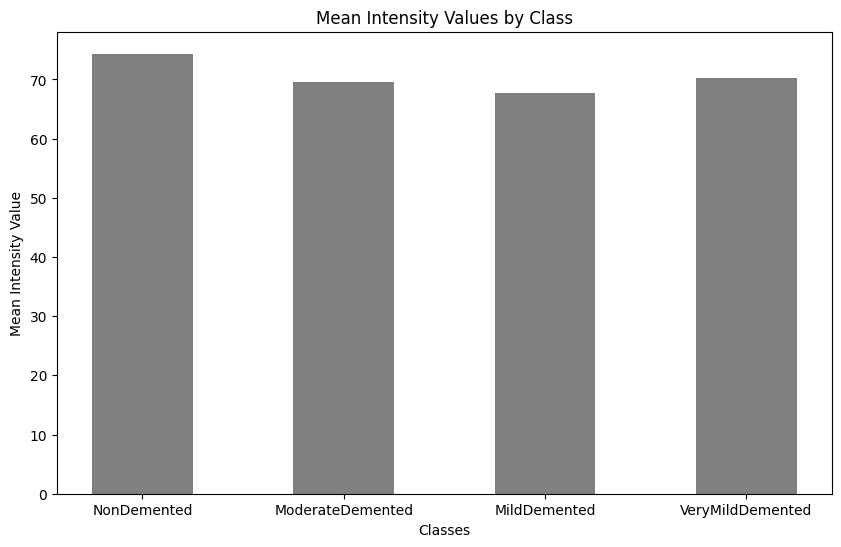

In [ ]:
check_color_distribution(alzheimer_train)

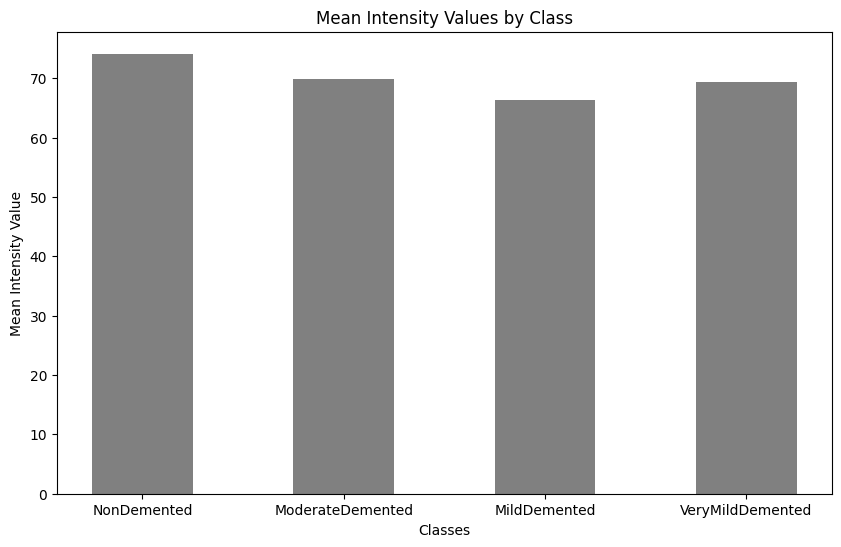

In [ ]:
check_color_distribution(alzheimer_test)

### 2.5. Visualizing Sample Images

In [ ]:
def show_images_in_grid(classifications, image_paths):
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))
  for i, (image_paths, classifications) in enumerate(zip(image_paths, classifications)):
    image = cv2.imread(image_paths, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.uint8)
    axs[i // 2, i % 2].imshow(image, cmap='gray')
    axs[i // 2, i % 2].set_title(classifications)
    axs[i // 2, i % 2].axis('off')
  plt.tight_layout()
  plt.show()


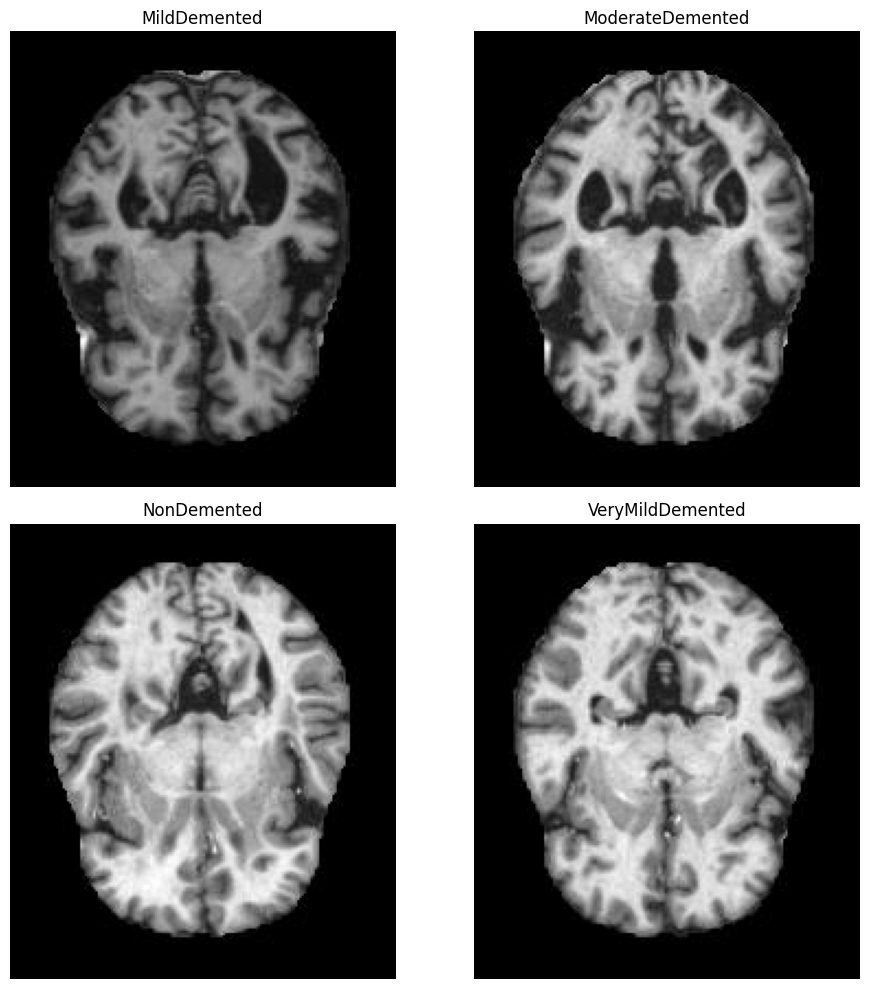

In [ ]:
classifications = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
demo_img_paths = [
    alzheimer_train + "/MildDemented/mildDem0.jpg",
    alzheimer_train + "/ModerateDemented/moderateDem0.jpg",
    alzheimer_train + "/NonDemented/nonDem0.jpg",
    alzheimer_train + "/VeryMildDemented/verymildDem0.jpg"
]
show_images_in_grid(classifications, demo_img_paths)